In [ ]:
import geopandas as gpd
import h3
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import entropy
from shapely.geometry import Polygon

In [ ]:
CITY = "budapest"
VERSION = "20250428"

In [ ]:
# define path for socioecon info
szk_path = "/mnt/common-ssd/zadorzsofi/telekom/BKK/data/szuperkupa_nap_zscores.pkl"
# district path
district_path = "/mnt/common-ssd/zadorzsofi/telekom/BKK/data/city_shapes/Budapest/budapest_districts.shp"
# Gross labour income per capita by income deciles for Hungary
income_path = "/mnt/common-ssd/zadorzsofi/telekom/BKK/data/socioecon/stadat-jov0003-14.8.1.2_income_deciles_total.csv"
# district income path - gross mean income
district_income_path = "/mnt/common-ssd/zadorzsofi/telekom/BKK/data/socioecon/bp_gross_mean_income2024.xlsx"
# multimodal gini path
gini_house_multi_path = (
    "/mnt/common-ssd/zadorzsofi/telekom/BKK/data/socioecon/multimodal_stop_gini.csv"
)
# walk15 gini path
gini_house_walk_path = (
    "/mnt/common-ssd/zadorzsofi/telekom/BKK/data/socioecon/walk15_stop_gini.csv"
)
city = "budapest"
version = "20250428"  # if "" then no version folder is selected
path = f"/mnt/common-ssd/pintergreg/stop_accessibility/output/{CITY}/{VERSION}/"


# Read the GeoJSON file where for each stop id we know the multimodal area (5 min walk + 10 min BKK) + ellipticity of this shape + size of the area
# and multipolygons describing the 5 min walk from each such station
multimodal = gpd.read_file(
    f"{path}/stop_geometries_from_walk.geojson", engine="pyogrio"
)
# Read GeoJSON file for 15 minute walking distance
walking = gpd.read_file(f"{path}/isochrones.geojson", engine="pyogrio")
# read centrality csv
centrality = pd.read_csv(
    f"{path}/merged.csv",
    dtype={
        "stop_id": str,
    },
)


# read in geojson for city boundary
bp = gpd.read_file(f"../../data/osm/{CITY}/boundary.geojson", engine="pyogrio")
# Read the pickle file into a DataFrame
szk_nap = pd.read_pickle(szk_path)
# read district geojson
dist = gpd.read_file(district_path, engine="pyogrio")
# income
income = pd.read_csv(income_path, header=1, index_col=0, delimiter=";", thousands=" ")
# distrcit income
dist_income = pd.read_excel(district_income_path)
# gini from house price
gini_house_multi = pd.read_csv(gini_house_multi_path)
gini_house_walk = pd.read_csv(gini_house_walk_path)

# Pipeline

0. Filter walking to 15min walk
1. match hexagons & other small shapes to walking15 shapes and multimodal
2. Append to socioecon data
3. For multimodal, count average income, nr poor households/total households (poor household %) within area
4. For walking15 count within area
5. Calculate a) low income ratio b) Gini, c) income entropy -- however how? income level at each location? and characterise low/mid/high income for Gini?

### Filter walking

In [ ]:
walking15 = walking[(walking["costing"] == "walk") & (walking["range"] == 15)]
walking15 = walking15.copy()
walking15.drop(columns=["costing", "range"], inplace=True)

### 1. Match hex to shapes

In [ ]:
def add_hexagon_ids(geo_df, hex_resolution=10):
    """
    Adds a column of H3 hexagon IDs to a GeoDataFrame based on its geometries.

    Parameters:
    geo_df (GeoDataFrame): The input GeoDataFrame with geometries.
    hex_resolution (int): The H3 resolution level to use.

    Returns:
    GeoDataFrame: The GeoDataFrame with a new column 'hexagon_ids' containing the hexagon IDs.
    """
    hexagon_lists = []  # List to store hexagon IDs for each geometry

    # Loop through each geometry in the GeoDataFrame
    for idx, row in geo_df.iterrows():
        # Ensure the geometry is valid
        if row.geometry.is_valid:
            # Initialize an empty set to collect hex IDs
            hex_ids = set()

            # Check if the geometry is a MultiPolygon
            if row.geometry.geom_type == "MultiPolygon":
                # Loop through each Polygon in the MultiPolygon
                for polygon in row.geometry.geoms:
                    geom_dict = polygon.__geo_interface__  # Get GeoJSON representation
                    hex_ids.update(
                        h3.polyfill(geom_dict, hex_resolution, geo_json_conformant=True)
                    )
            else:
                # Handle Polygon geometries
                geom_dict = row.geometry.__geo_interface__  # Get GeoJSON representation
                hex_ids.update(
                    h3.polyfill(geom_dict, hex_resolution, geo_json_conformant=True)
                )

            # Add the hex IDs to the list
            hexagon_lists.append(list(hex_ids))
        else:
            # Add an empty list for invalid geometries
            hexagon_lists.append([])

    # Add the hexagon IDs as a new column to the GeoDataFrame
    geo_df["hexagon_ids"] = hexagon_lists

    # Drop rows where 'hexagon_ids' column is empty or contains NaN
    geo_df = geo_df[geo_df["hexagon_ids"].apply(lambda x: bool(x))]

In [ ]:
# match hexagons to 15min walking areas
add_hexagon_ids(walking15, hex_resolution=10)
# Explode the hexagon_ids column in the walking GeoDataFrame
walking15_exploded = walking15.explode("hexagon_ids").rename(
    columns={"hexagon_ids": "h3_id"}
)

In [ ]:
# match hexagons to Multimodal areas
add_hexagon_ids(multimodal, hex_resolution=10)
# Explode the hexagon_ids column in the walking GeoDataFrame
multimodal_exploded = multimodal.explode("hexagon_ids").rename(
    columns={"hexagon_ids": "h3_id"}
)

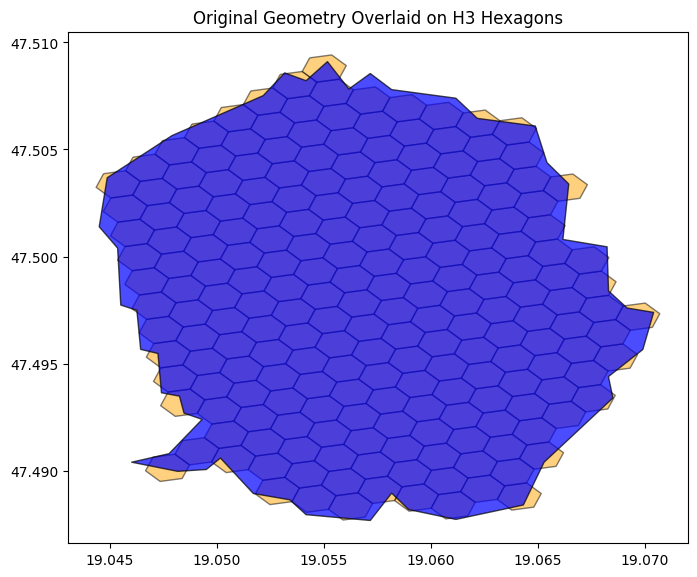

In [ ]:
first_geom = walking15.iloc[5].geometry  # Extract the first row's geometry
hex_ids = walking15.iloc[5].hexagon_ids  # Extract H3 hexagon IDs

# Convert H3 hexagon IDs to Shapely Polygons
hex_geometries = [Polygon(h3.h3_to_geo_boundary(h, geo_json=True)) for h in hex_ids]

# Create a GeoDataFrame for the hexagons
hex_gdf = gpd.GeoDataFrame(geometry=hex_geometries, crs=walking15.crs)

# Plot both layers on top of each other
fig, ax = plt.subplots(figsize=(8, 8))

# Plot H3 hexagons
hex_gdf.plot(ax=ax, color="orange", edgecolor="black", alpha=0.5, label="H3 Hexagons")

# Plot original geometry on top
gpd.GeoSeries([first_geom]).plot(
    ax=ax, color="blue", edgecolor="black", alpha=0.7, label="Original Geometry"
)

ax.set_title("Original Geometry Overlaid on H3 Hexagons")
plt.show()

### # 2. Append to socioecon data

#### 0. Assign district level gross mean income to each hex in the district

In [ ]:
# Extract the numeric part from 'short_name' in districts2
dist["district_number"] = dist["short_name"].str.extract("(\d+)").astype(int)

# Merge the dataframes based on the district number
districts3 = pd.merge(
    dist,
    dist_income[["District", "Gross mean income monthly 2024"]],
    left_on="district_number",
    right_on="District",
    how="left",
)


def h3_to_polygon(h3_id):
    """Convert a H3 hexagon ID to a Shapely Polygon."""
    # Get the vertices of the hexagon using h3 library
    boundary = h3.h3_to_geo_boundary(h3_id, geo_json=True)
    # Convert the list of boundary points into a Polygon
    return Polygon(boundary)


# Apply the conversion for each raster_id in szk_nap
szk_nap["geometry"] = szk_nap["raster_id"].apply(h3_to_polygon)

# Now create a GeoDataFrame
szk_nap_gdf = gpd.GeoDataFrame(szk_nap, geometry="geometry", crs="EPSG:4326")

# Perform a spatial join to map hexagons to districts
szk_nap_gdf2 = gpd.sjoin(szk_nap_gdf, districts3, how="left")

szk_nap_gdf3 = szk_nap_gdf2.drop(
    columns=["geometry", "index_right", "name", "short_name", "district_number"]
)

In [34]:
szk_nap_gdf3.head()

,raster_id,traffic,remainers,loc_home,loc_work,loc_freq,sex_female,sex_male,sex_na,arpu_low,...,log_traffic_z_score_full,log_roam_z_score_full,log_local_z_score_full,log_traffic_z_score,log_roam_z_score,log_local_z_score,element,id,District,Gross mean income monthly 2024
87,8a1e0378c367fff,156.000000,46.428571,0.000000,6.428571,1.714286,46.571429,41.000000,68.428571,86.857143,...,0.685984,0.000000,0.685984,0.766493,0.000000,0.766493,relation,1606100.0,8.0,771000.0
255,8a1e037a85b7fff,365.714286,100.428571,23.428571,22.571429,11.428571,99.571429,103.571429,162.571429,183.000000,...,0.629836,1.815712,0.575585,0.698256,3.227631,0.633760,relation,1606101.0,6.0,847000.0
423,8a1e0378dd9ffff,91.285714,27.000000,0.000000,5.000000,1.428571,25.571429,24.428571,41.285714,44.857143,...,0.482651,0.000000,0.482651,0.526083,0.000000,0.526083,relation,1606100.0,8.0,771000.0
591,8a1e0363298ffff,65.714286,20.428571,2.142857,0.000000,0.000000,20.285714,18.428571,17.428571,37.714286,...,0.095352,0.000000,0.095352,0.101641,0.000000,0.101641,relation,1552463.0,10.0,698000.0
759,8a1e036ac98ffff,33.857143,2.428571,0.000000,0.000000,0.000000,6.000000,7.285714,6.857143,8.000000,...,0.583268,0.000000,0.583268,0.642815,0.000000,0.642815,relation,1550597.0,23.0,688000.0


In [ ]:
# Merge 15 min walk with df_szk on the H3 hexagon IDs
stop_walk15 = pd.merge(
    walking15_exploded, szk_nap_gdf3, left_on="h3_id", right_on="raster_id", how="left"
)

In [ ]:
# Merge with df_szk on the H3 hexagon IDs
stop_multimodal = pd.merge(
    multimodal_exploded, szk_nap_gdf2, left_on="h3_id", right_on="raster_id", how="left"
)

### 3. and 4. Get socioecon information for each multimodal and walking area

In [ ]:
# Define the columns to sum and the column to average
columns_to_sum = [
    "traffic",
    "sex_female",
    "sex_male",
    "sex_na",
    "arpu_low",
    "arpu_mid",
    "arpu_high",
    "arpu_na",
    "age_young",
    "age_mid",
    "age_old",
]

column_to_avg = "Gross mean income monthly 2024"

# For 15-min walking area
nr_ppl_per_stop_walk15 = (
    stop_walk15.groupby("stop_id")
    .agg(
        {
            **{col: "sum" for col in columns_to_sum},  # Sum columns
            column_to_avg: "mean",  # Average for income - so it takes into account if area is in several districts
        }
    )
    .reset_index()
)

# For multimodal area
nr_ppl_per_stop_multimodal = (
    stop_multimodal.groupby("stop_id")
    .agg(
        {
            **{col: "sum" for col in columns_to_sum},  # Sum  columns
            column_to_avg: "mean",  # Average for 'Gross mean income monthly 2024'
        }
    )
    .reset_index()
)

### Calculate socio-econ changes

#### a) Income entropy

In [ ]:
nr_ppl_per_stop_multimodal2 = nr_ppl_per_stop_multimodal.set_index("stop_id")
multimodal_rev = nr_ppl_per_stop_multimodal2.drop(
    columns=[
        "traffic",
        "sex_female",
        "sex_male",
        "sex_na",
        "age_young",
        "age_mid",
        "age_old",
        "arpu_high",
        "Gross mean income monthly 2024",
    ]
)

In [ ]:
multimodal_rev["entropy"] = multimodal_rev.apply(
    lambda row: entropy(row.values, 3), axis=1
)

In [ ]:
nr_ppl_per_stop_multimodal = nr_ppl_per_stop_multimodal.merge(
    multimodal_rev[["entropy"]],
    left_on="stop_id",
    right_on=multimodal_rev.index,
    how="left",
)

In [ ]:
nr_ppl_per_stop_walk15_2 = nr_ppl_per_stop_walk15.set_index("stop_id")
walk15_rev = nr_ppl_per_stop_walk15_2.drop(
    columns=[
        "traffic",
        "sex_female",
        "sex_male",
        "sex_na",
        "age_young",
        "age_mid",
        "age_old",
        "arpu_high",
        "Gross mean income monthly 2024",
    ]
)

In [ ]:
walk15_rev["entropy"] = walk15_rev.apply(lambda row: entropy(row.values, 3), axis=1)
nr_ppl_per_stop_walk15 = nr_ppl_per_stop_walk15.merge(
    walk15_rev[["entropy"]], left_on="stop_id", right_on=walk15_rev.index, how="left"
)

/tmp/ipykernel_2541198/2723321990.py:4: RuntimeWarning: invalid value encountered in scalar divide
  rel_freq = list([i/sum(arr) for i in arr])


#### b) Revenue index

In [ ]:
# Generate Weighted average for multimodal areas

# Calculate the total number of people at each stop
nr_ppl_per_stop_multimodal["total"] = (
    nr_ppl_per_stop_multimodal["arpu_low"]
    + nr_ppl_per_stop_multimodal["arpu_mid"]
    + nr_ppl_per_stop_multimodal["arpu_high"]
)

# Calculate the proportion of each category
nr_ppl_per_stop_multimodal["P_low"] = (
    nr_ppl_per_stop_multimodal["arpu_low"] / nr_ppl_per_stop_multimodal["total"]
)
nr_ppl_per_stop_multimodal["P_mid"] = (
    nr_ppl_per_stop_multimodal["arpu_mid"] / nr_ppl_per_stop_multimodal["total"]
)
nr_ppl_per_stop_multimodal["P_high"] = (
    nr_ppl_per_stop_multimodal["arpu_high"] / nr_ppl_per_stop_multimodal["total"]
)

# Calculate the revenue index using weights -1, 0, and 1
nr_ppl_per_stop_multimodal["revenue_index"] = (
    (-1 * nr_ppl_per_stop_multimodal["P_low"])
    + (0 * nr_ppl_per_stop_multimodal["P_mid"])
    + (1 * nr_ppl_per_stop_multimodal["P_high"])
)

In [ ]:
# Generate Weighted average for multimodal areas

# Calculate the total number of people at each stop
nr_ppl_per_stop_walk15["total"] = (
    nr_ppl_per_stop_walk15["arpu_low"]
    + nr_ppl_per_stop_walk15["arpu_mid"]
    + nr_ppl_per_stop_walk15["arpu_high"]
)

# Calculate the proportion of each category
nr_ppl_per_stop_walk15["P_low"] = (
    nr_ppl_per_stop_walk15["arpu_low"] / nr_ppl_per_stop_walk15["total"]
)
nr_ppl_per_stop_walk15["P_mid"] = (
    nr_ppl_per_stop_walk15["arpu_mid"] / nr_ppl_per_stop_walk15["total"]
)
nr_ppl_per_stop_walk15["P_high"] = (
    nr_ppl_per_stop_walk15["arpu_high"] / nr_ppl_per_stop_walk15["total"]
)

# Calculate the revenue index using weights -1, 0, and 1
nr_ppl_per_stop_walk15["revenue_index"] = (
    (-1 * nr_ppl_per_stop_walk15["P_low"])
    + (0 * nr_ppl_per_stop_walk15["P_mid"])
    + (1 * nr_ppl_per_stop_walk15["P_high"])
)

#### c) Gini coefficient

##### 1. Calculate % difference from Hungary income deciles to low-income, medium income and high income

In [ ]:
# For Helsinki I used these deciles, so I'll continue using them for consistency

# In the postal code data low-income is nr of people in decile 1 and 2
# High-income is nr of people in decile 9-10
# So I want to calculate % difference in income from median for low and high income groups and use that in the GINI

In [ ]:
# Compute Bp's Income Differences between median (5th decile) and low/high income
median_bp = income.loc[income.index == "5th income decile", "2020"]

low_deciles_avg = income.loc[
    income.index.isin(["1st income decile", "2nd income decile"]), "2020"
].mean()
high_deciles_avg = income.loc[
    income.index.isin(["9th income decile", "10th income decile"]), "2020"
].mean()

low_income_diff = (low_deciles_avg - median_bp) / median_bp
high_income_diff = (high_deciles_avg - median_bp) / median_bp

In [ ]:
# Estimate Representative Incomes for walking
nr_ppl_per_stop_walk15["Low_Income_Rep"] = nr_ppl_per_stop_walk15[
    "Gross mean income monthly 2024"
] * (1 + float(low_income_diff.iloc[0]))
nr_ppl_per_stop_walk15["High_Income_Rep"] = nr_ppl_per_stop_walk15[
    "Gross mean income monthly 2024"
] * (1 + float(high_income_diff.iloc[0]))

# Estimate Representative Incomes for multimodal
nr_ppl_per_stop_multimodal["Low_Income_Rep"] = nr_ppl_per_stop_multimodal[
    "Gross mean income monthly 2024"
] * (1 + float(low_income_diff.iloc[0]))
nr_ppl_per_stop_multimodal["High_Income_Rep"] = nr_ppl_per_stop_multimodal[
    "Gross mean income monthly 2024"
] * (1 + float(high_income_diff.iloc[0]))

##### 2. Apply % difference to walking and multimodal areas

In [ ]:
# creating an array (column), where each income category is repeated the houshold nr times
# this will be used for gini calculation
def create_income_distribution(row):
    low_income = [row["Low_Income_Rep"]] * int(row["arpu_low"])
    middle_income = [row["Gross mean income monthly 2024"]] * int(row["arpu_mid"])
    high_income = [row["High_Income_Rep"]] * int(row["arpu_high"])
    return low_income + middle_income + high_income

In [ ]:
# define gini
def gini(array):
    """Calculate the Gini coefficient of a numpy array.
    Based on code from: https://github.com/oliviaguest/gini"""
    array = np.array(
        array, dtype=float
    )  # change from Olivia: Convert to NumPy array and flatten
    if (
        array.size == 0 or np.sum(array) == 0
    ):  # change from Olivia, as I have empty arrays
        return np.nan  # handle 0 divisions
    array = np.sort(array)
    n = array.size
    index = np.arange(1, n + 1)
    return (np.sum((2 * index - n - 1) * array)) / (n * np.sum(array))

In [ ]:
nr_ppl_per_stop_walk15["Income_Distribution"] = nr_ppl_per_stop_walk15.apply(
    create_income_distribution, axis=1
)
nr_ppl_per_stop_walk15["gini"] = nr_ppl_per_stop_walk15["Income_Distribution"].apply(
    gini
)

In [ ]:
nr_ppl_per_stop_multimodal["Income_Distribution"] = nr_ppl_per_stop_multimodal.apply(
    create_income_distribution, axis=1
)
nr_ppl_per_stop_multimodal["gini"] = nr_ppl_per_stop_multimodal[
    "Income_Distribution"
].apply(gini)

##### 2. Merge Gini from housing prices

In [ ]:
# Rename column in gini_house_multi
gini_house_multi = gini_house_multi.rename(columns={"multimodal_gini": "gini_house"})

# Rename column in gini_house_walk
gini_house_walk = gini_house_walk.rename(columns={"walk15_gini": "gini_house"})

# Merge for multimodal
nr_ppl_per_stop_multimodal = pd.merge(
    gini_house_multi,
    nr_ppl_per_stop_multimodal,
    on="stop_id",
    how="left",  # or 'inner' depending on your goal
)

# Merge for walk
nr_ppl_per_stop_walk15 = pd.merge(
    gini_house_walk, nr_ppl_per_stop_walk15, on="stop_id", how="left"
)

#### Calculate socioecon ratios

In [ ]:
nr_ppl_per_stop_walk15["fem_ratio"] = (
    nr_ppl_per_stop_walk15["sex_female"] / nr_ppl_per_stop_walk15["traffic"]
)
nr_ppl_per_stop_walk15["arpu_low_ratio"] = (
    nr_ppl_per_stop_walk15["arpu_low"] / nr_ppl_per_stop_walk15["traffic"]
)
nr_ppl_per_stop_walk15["arpu_high_ratio"] = (
    nr_ppl_per_stop_walk15["arpu_high"] / nr_ppl_per_stop_walk15["traffic"]
)
nr_ppl_per_stop_walk15["young_ratio"] = (
    nr_ppl_per_stop_walk15["age_young"] / nr_ppl_per_stop_walk15["traffic"]
)
nr_ppl_per_stop_walk15["old_ratio"] = (
    nr_ppl_per_stop_walk15["age_old"] / nr_ppl_per_stop_walk15["traffic"]
)

In [ ]:
nr_ppl_per_stop_multimodal["fem_ratio"] = (
    nr_ppl_per_stop_multimodal["sex_female"] / nr_ppl_per_stop_multimodal["traffic"]
)
nr_ppl_per_stop_multimodal["arpu_low_ratio"] = (
    nr_ppl_per_stop_multimodal["arpu_low"] / nr_ppl_per_stop_multimodal["traffic"]
)
nr_ppl_per_stop_multimodal["arpu_high_ratio"] = (
    nr_ppl_per_stop_multimodal["arpu_high"] / nr_ppl_per_stop_multimodal["traffic"]
)
nr_ppl_per_stop_multimodal["young_ratio"] = (
    nr_ppl_per_stop_multimodal["age_young"] / nr_ppl_per_stop_multimodal["traffic"]
)
nr_ppl_per_stop_multimodal["old_ratio"] = (
    nr_ppl_per_stop_multimodal["age_old"] / nr_ppl_per_stop_multimodal["traffic"]
)

### Merge different datasets

In [ ]:
# Merge the DataFrames on stop_id with suffixes but remove Income_Dist before merging as I won't need this in the final df
nr_ppl_per_stop_comparison = pd.merge(
    nr_ppl_per_stop_multimodal.drop(columns=["Income_Distribution"]),
    nr_ppl_per_stop_walk15.drop(columns=["Income_Distribution"]),
    on="stop_id",
    suffixes=("_multimodal", "_walk15"),
)

In [ ]:
# calculate change of some variables
nr_ppl_comparison = nr_ppl_per_stop_comparison.dropna()
nr_ppl_comparison = nr_ppl_comparison.copy()

nr_ppl_comparison.loc[:, "fem_change"] = (
    nr_ppl_comparison["fem_ratio_multimodal"] - nr_ppl_comparison["fem_ratio_walk15"]
)
nr_ppl_comparison.loc[:, "arpu_low_change"] = (
    nr_ppl_comparison["arpu_low_ratio_multimodal"]
    - nr_ppl_comparison["arpu_low_ratio_walk15"]
)
nr_ppl_comparison.loc[:, "young_change"] = (
    nr_ppl_comparison["young_ratio_multimodal"]
    - nr_ppl_comparison["young_ratio_walk15"]
)
nr_ppl_comparison.loc[:, "old_change"] = (
    nr_ppl_comparison["old_ratio_multimodal"] - nr_ppl_comparison["old_ratio_walk15"]
)

In [ ]:
# Calculate percentage change
nr_ppl_comparison["percent_change_gini"] = np.where(
    nr_ppl_comparison["gini_walk15"] == 0,
    np.nan,  # because division by 0 is not meaningful, or can be flag value as there is more inequality in the multimodal -- what should be the value?
    (nr_ppl_comparison["gini_multimodal"] - nr_ppl_comparison["gini_walk15"])
    / nr_ppl_comparison["gini_walk15"]
    * 100,
)

nr_ppl_comparison["percent_change_house_gini"] = np.where(
    nr_ppl_comparison["gini_house_walk15"] == 0,
    np.nan,  # because division by 0 is not meaningful, or can be flag value as there is more inequality in the multimodal -- what should be the value?
    (nr_ppl_comparison["gini_house_multimodal"] - nr_ppl_comparison["gini_walk15"])
    / nr_ppl_comparison["gini_house_walk15"]
    * 100,
)

nr_ppl_comparison["percent_change_rev_index"] = (
    (
        nr_ppl_comparison["revenue_index_multimodal"]
        - nr_ppl_comparison["revenue_index_walk15"]
    )
    / nr_ppl_comparison["revenue_index_walk15"]
) * 100

nr_ppl_comparison["percent_change_entropy"] = (
    (nr_ppl_comparison["entropy_multimodal"] - nr_ppl_comparison["entropy_walk15"])
    / nr_ppl_comparison["entropy_walk15"]
) * 100

In [ ]:
# Gini log change
nr_ppl_comparison["log_change_gini"] = np.where(
    (nr_ppl_comparison["gini_multimodal"] > 0) & (nr_ppl_comparison["gini_walk15"] > 0),
    np.log(nr_ppl_comparison["gini_multimodal"] / nr_ppl_comparison["gini_walk15"]),
    np.nan,
)

# Gini (households) log change
nr_ppl_comparison["log_change_house_gini"] = np.where(
    (nr_ppl_comparison["gini_house_multimodal"] > 0)
    & (nr_ppl_comparison["gini_house_walk15"] > 0),
    np.log(
        nr_ppl_comparison["gini_house_multimodal"]
        / nr_ppl_comparison["gini_house_walk15"]
    ),
    np.nan,
)

# Revenue index log change
nr_ppl_comparison["log_change_rev_index"] = np.where(
    (nr_ppl_comparison["revenue_index_multimodal"] > 0)
    & (nr_ppl_comparison["revenue_index_walk15"] > 0),
    np.log(
        nr_ppl_comparison["revenue_index_multimodal"]
        / nr_ppl_comparison["revenue_index_walk15"]
    ),
    np.nan,
)

# Entropy log change
nr_ppl_comparison["log_change_entropy"] = np.where(
    (nr_ppl_comparison["entropy_multimodal"] > 0)
    & (nr_ppl_comparison["entropy_walk15"] > 0),
    np.log(
        nr_ppl_comparison["entropy_multimodal"] / nr_ppl_comparison["entropy_walk15"]
    ),
    np.nan,
)

/mnt/common-ssd/zadorzsofi/telekom/.venv/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [ ]:
centrality.drop_duplicates(subset=["stop_id"], inplace=True)

In [ ]:
# Merge the DataFrames
nr_ppl_comparison2 = pd.merge(nr_ppl_comparison, centrality, on="stop_id", how="inner")

In [ ]:
nr_ppl_comparison2.to_csv(
    "/mnt/common-ssd/zadorzsofi/telekom/BKK/data/socioecon_change/bp_socioecon_merged5.csv",
    index=False,
)